In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add      

In [9]:
def readTextFile(path):
    with open(path) as f:
        captions=f.read()
    
    return captions

In [10]:
captions=readTextFile("./Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
captions=captions.split('\n')[:-1]

In [11]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [12]:
print(len(captions))

40460


In [13]:
first,second=captions[8].split('\t')
print(first)
print(first.split(".")[0])
print(second)

1001773457_577c3a7d70.jpg#3
1001773457_577c3a7d70
Two dogs of different breeds looking at each other on the road .


In [14]:
#Dictionary to map each image to it's caption

descriptions={}

for x in captions:
    first,second=x.split('\t')
    img_name=first.split(".")[0]
    
    #if the image id is already present or not
    
    if descriptions.get(img_name) is None:
        descriptions[img_name]=[]
        
    
    descriptions[img_name].append(second)
    

In [15]:
descriptions["2513260012_03d33305cf"]

['A black dog is running after a white dog in the snow .',
 'Black dog chasing brown dog through snow',
 'Two dogs chase each other across the snowy ground .',
 'Two dogs play together in the snow .',
 'Two dogs running through a low lying body of water .']

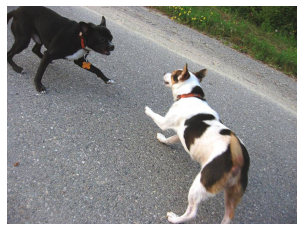

In [16]:
img_path="./Flickr_Data/Flickr_Data/Images/"
import cv2
import matplotlib.pyplot as plt

img=cv2.imread(img_path+"1001773457_577c3a7d70.jpg")
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

### Data Cleaning

In [17]:
def clean_text(sentence):
    sentence=sentence.lower()
    sentence=re.sub("[^a-z]+"," ",sentence)
    sentence=sentence.split()
    
    sentence=[s for s in sentence if len(s)>1]
    sentence=" ".join(sentence)
    return sentence


In [18]:
clean_text("A black dog and a spotted dog are fighting")

'black dog and spotted dog are fighting'

In [19]:
# Clean all captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i]=clean_text(caption_list[i])


In [20]:
descriptions["1001773457_577c3a7d70"]

['black dog and spotted dog are fighting',
 'black dog and tri colored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [21]:
# Write the data to text file
with open("descriptions.txt","w") as f:
    f.write(str(descriptions))

In [22]:
#vocabulary
descriptions=None
with open("descriptions.txt",'r') as f:
    descriptions=f.read()
    
    json_acceptable_string=descriptions.replace("'","\"")
    descriptions=json.loads(json_acceptable_string)
    

In [23]:
print(type(descriptions))

<class 'dict'>


In [24]:
vocab=set()

for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

In [25]:
print(len(vocab))

8424


In [26]:
# total words across all sentences

total_words=[]
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]

In [27]:
print(len(total_words))

373837


In [28]:
#filter words from the vocab according to certain thrreshold frequency

import collections

counter=collections.Counter(total_words)
freq_cnt=dict(counter)
print(len(freq_cnt.keys()))

8424


In [29]:
#sort this dictionanry according to the frequency count

sorted_freq_cnt=sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

#filter
threshold=10
sorted_freq_cnt=[x for x in sorted_freq_cnt if x[1]>threshold]
total_words=[x[0] for x in sorted_freq_cnt]
print(len(total_words))

1845


### Prepare Train-Test Data

In [30]:


train_file_data=readTextFile("./Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data=readTextFile("./Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")


In [31]:
train=[row.split(".")[0] for row in train_file_data.split("\n")[:-1]]

test=[row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [32]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [33]:
test[:5]

['3385593926_d3e9c21170',
 '2677656448_6b7e7702af',
 '311146855_0b65fdb169',
 '1258913059_07c613f7ff',
 '241347760_d44c8d3a01']

In [34]:
#prepare descriptions for the training data
# Add a start and end token to our training data

train_descriptions={}

for img_id in train:
    train_descriptions[img_id]=[]
    for cap in descriptions[img_id]:
        cap_to_append="startseq "+cap+" endseq"
        train_descriptions[img_id].append(cap_to_append)

In [35]:
train_descriptions["2513260012_03d33305cf"]

['startseq black dog is running after white dog in the snow endseq',
 'startseq black dog chasing brown dog through snow endseq',
 'startseq two dogs chase each other across the snowy ground endseq',
 'startseq two dogs play together in the snow endseq',
 'startseq two dogs running through low lying body of water endseq']

### Transfer Learning

In [36]:
model=ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [37]:
model_new=Model(model.input,model.layers[-2].output)

In [38]:
def preprocess_img(img):
    img=image.load_img(img,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    
    #normailisation
    img=preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


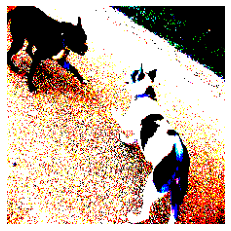

In [39]:
img=preprocess_img(img_path+"1001773457_577c3a7d70.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [40]:
def encode_image(img):
    img=preprocess_img(img)
    feature_vector=model_new.predict(img)   
    feature_vector=feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    
    return feature_vector
    

In [41]:
encode_image(img_path+"2513260012_03d33305cf.jpg")

array([0.34707975, 0.51159143, 0.08728842, ..., 1.1897299 , 0.04043847,
       0.1527107 ], dtype=float32)

In [35]:
#image_id--->feature vector
start=time()
encoding_train={}

for ix,img_id in enumerate(train):
    image_path=img_path+"/"+img_id+".jpg"
    encoding_train[img_id]=encode_image(image_path)
     
    if ix%100==0:
        print("Encoding in Progress Time Step %d"%ix)
        
end_t=time()
print("Total time taken :",end_t-start)

Encoding in Progress Time Step 0
Encoding in Progress Time Step 100
Encoding in Progress Time Step 200
Encoding in Progress Time Step 300
Encoding in Progress Time Step 400
Encoding in Progress Time Step 500
Encoding in Progress Time Step 600
Encoding in Progress Time Step 700
Encoding in Progress Time Step 800
Encoding in Progress Time Step 900
Encoding in Progress Time Step 1000
Encoding in Progress Time Step 1100
Encoding in Progress Time Step 1200
Encoding in Progress Time Step 1300
Encoding in Progress Time Step 1400
Encoding in Progress Time Step 1500
Encoding in Progress Time Step 1600
Encoding in Progress Time Step 1700
Encoding in Progress Time Step 1800
Encoding in Progress Time Step 1900
Encoding in Progress Time Step 2000
Encoding in Progress Time Step 2100
Encoding in Progress Time Step 2200
Encoding in Progress Time Step 2300
Encoding in Progress Time Step 2400
Encoding in Progress Time Step 2500
Encoding in Progress Time Step 2600
Encoding in Progress Time Step 2700
Enco

In [36]:
#Store everything to the disk

with open("encoded_train_features.pkl","wb") as f:  #write binary mode
    pickle.dump(encoding_train,f)  # file pointer



In [62]:
#image_id--->feature vector
start=time()
encoding_test={}

for ix,img_id in enumerate(test):
    image_path=img_path+"/"+img_id+".jpg"
    encoding_test[img_id]=encode_image(image_path)
     
    if ix%100==0:
        print("Encoding in Progress Time Step %d"%ix)
        
end_t=time()
print("Total time taken(test) :",end_t-start)

Encoding in Progress Time Step 0
Encoding in Progress Time Step 100
Encoding in Progress Time Step 200
Encoding in Progress Time Step 300
Encoding in Progress Time Step 400
Encoding in Progress Time Step 500
Encoding in Progress Time Step 600
Encoding in Progress Time Step 700
Encoding in Progress Time Step 800
Encoding in Progress Time Step 900
Total time taken(test) : 197.4308807849884


In [63]:
#Store everything to the disk

with open("encoded_test_features.pkl","wb") as f:  #write binary mode
    pickle.dump(encoding_test,f)  # file pointer

In [64]:
with open("./encoded_train_features.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)


In [65]:
with open("./encoded_test_features.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)
    


# Data preprocessing for Captions

In [66]:
# vocab
len(total_words)

1845

In [67]:
word_to_idx= {}
idx_to_word= {}
for i,word in enumerate(total_words):
    word_to_idx[word]=i+1
    idx_to_word[i+1]=word


In [68]:
word_to_idx["dog"]
idx_to_word[1]

print(len(idx_to_word))

1845


In [69]:
#two special words

idx_to_word[1846]='startseq'
word_to_idx['startseq']=1846


idx_to_word[1847]='endseq'
word_to_idx['endseq']=1847

vocab_size=len(word_to_idx)+1
print(vocab_size)


1848


In [70]:
max_len=0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len=max(max_len,len(cap.split()))
        
print(max_len)

35


# Data Loader(Generator)

In [71]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2,y=[],[],[]
    
    n=0
    while True:
        for key,desc_list in train_descriptions.items():
            n+=1
            
            photo=encoding_train[key]
            
            
            for desc in desc_list:
                seq=[word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi=seq[0:i]
                    yi=seq[i]
                    
                    xi=pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi=to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo) #2048 dim vector
                    X2.append(xi) #35 dim vector
                    y.append(yi) #vocab size
                if n==batch_size:
                    yield [np.array(X1),np.array(X2)],np.array(y)
                    X1,X2,y=[],[],[]
                    n=0
                    
                    

In [72]:
f=open("./glove.6B.50D.txt",encoding='utf8')

In [73]:
embedding_index={}

for line in f:
    values=line.split()

    word=values[0]
    word_embedding=np.asarray(values[1:],dtype='float')
    embedding_index[word]=word_embedding


In [74]:
f.close()

In [75]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [76]:
def get_embedding_matrix():
    emb_dim=50
    matrix=np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector=embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx]=embedding_vector
            
    return matrix
    

In [77]:
embedding_matrix=get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [78]:
embedding_matrix[1847]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Model Architecture

In [79]:
input_img_features=Input(shape=(2048,))
inp_img1=Dropout(0.3)(input_img_features)
inp_img2=Dense(256,activation='relu')(inp_img1)


In [80]:
input_captions=Input(shape=(max_len,))
inp_cap1=Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2=Dropout(0.3)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2)

In [81]:
decoder1=add([inp_img2,inp_cap3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

model=Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [82]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_5[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_4[0][0]                    
____________________________________________________________________________________________

In [83]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False

model.compile(loss='categorical_crossentropy',optimizer='adam')

In [84]:
epochs = 30
batch_size = 3
steps = len(train_descriptions)//batch_size

In [88]:
def train():
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [89]:
train()

2000/2000 [==============================] - 597s 298ms/step - loss: 2.3874


In [90]:
model = load_model("./model_weights/model_9.h5")

In [91]:
def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='endseq':
            break
        
        
    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

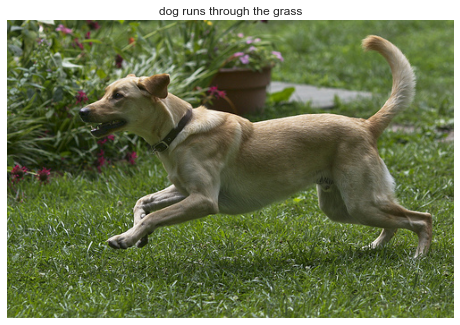

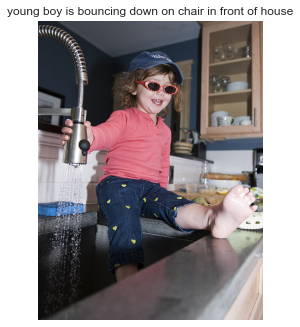

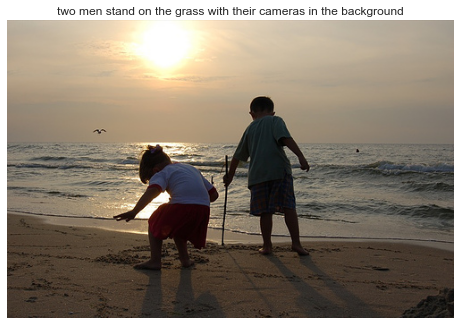

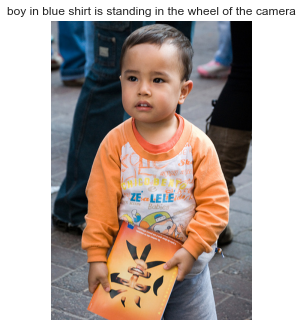

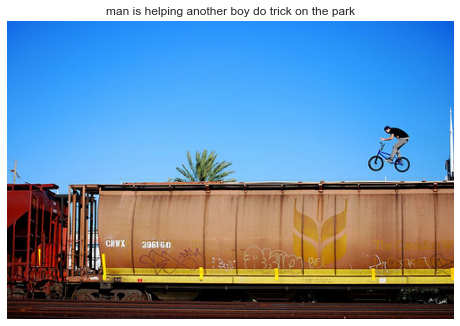

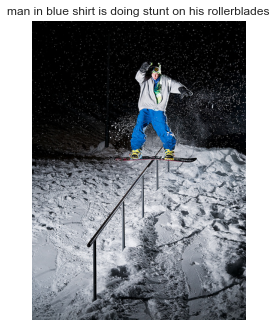

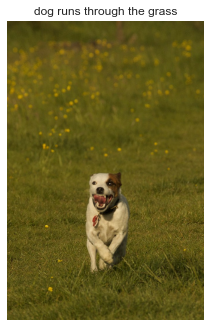

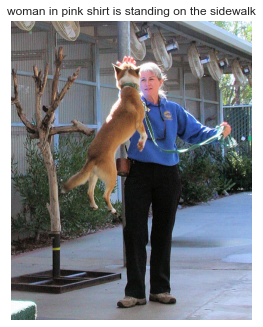

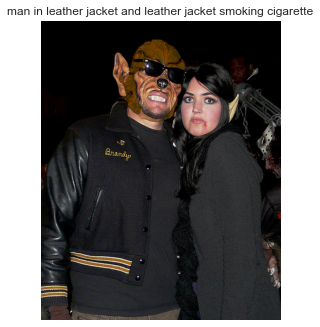

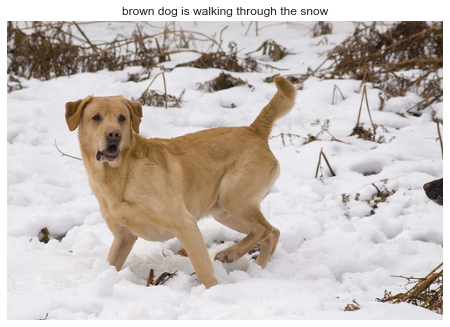

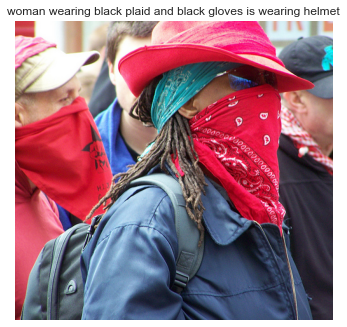

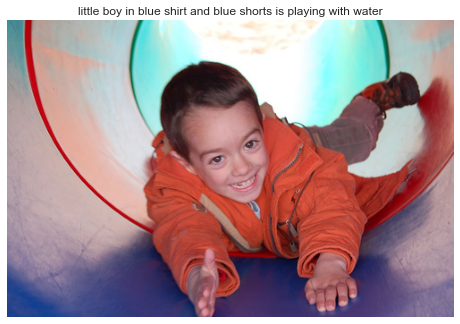

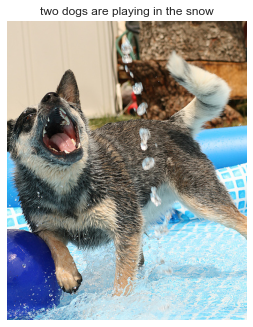

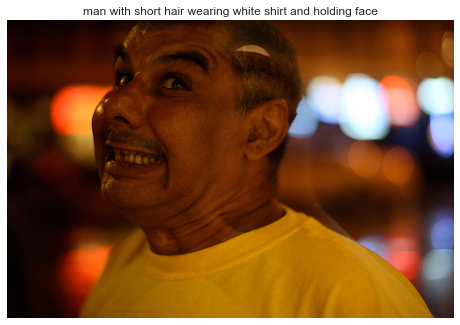

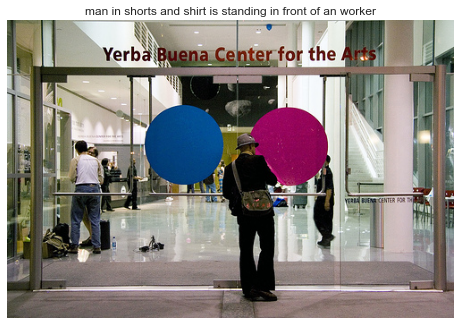

In [101]:
 plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape(1,2048)
    
    i = plt.imread("./Flickr_Data/Flickr_Data/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()